In [1]:
import sys
sys.path.append('/lfs/1/danfu/metal')
import metal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
import numpy as np
from scipy.sparse import csr_matrix
import os
from tqdm import tqdm
import random

from metal.analysis import lf_summary
from metal.label_model.baselines import MajorityLabelVoter
from metal.label_model import LabelModel

# Load Shot Data

In [4]:
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)

In [5]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))

In [6]:
clips = shots.dilate(1).coalesce().dilate(-1)

100%|██████████| 28/28 [00:00<00:00, 34766.29it/s]


In [7]:
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()

In [8]:
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}

In [9]:
video_ids = sorted(list(clips.get_allintervals().keys()))

In [10]:
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}

In [11]:
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

# Load Weak Labels

In [12]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)

In [14]:
labeling_function_folders = [
    '../../data/shot_detection_weak_labels/rgb_hists',
    '../../data/shot_detection_weak_labels/hsv_hists',
#     '../../data/shot_detection_weak_labels/flow_hists_magnitude', # this is just really really bad
    '../../data/shot_detection_weak_labels/flow_hists_diffs',
    '../../data/shot_detection_weak_labels/face_counts',
    '../../data/shot_detection_weak_labels/face_positions'
]

In [13]:
# Or load weak labels
with open('../../data/shot_detection_weak_labels/all_labels.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

In [14]:
weak_labels_gt_only = [
    {
        video_id: [
            lf[video_id][f-1]
            for f in frames_per_video[video_id]
        ]
        for video_id in sorted(list(clips.get_allintervals().keys()))
    }
    for lf in weak_labels_all_movies
]

# Train LabelModel

In [16]:
video_ids_all = list(frame_counts.keys())

In [17]:
train_movies_all = sorted(list(set(video_ids_all).difference(set(clips.get_allintervals().keys()))))

In [18]:
test_videos = sorted(list(clips.get_allintervals().keys()))

## Frame Based

In [19]:
L_train_everything = csr_matrix([
    [
        label
        for video_id in train_movies_all
        for label in lf[video_id]
    ]
    for lf in weak_labels_all_movies
]).transpose()

Y_test = np.array([
    label
    for video_id in test_videos
    for label in ground_truth[video_id]
])
L_test = csr_matrix([
    [
        label
        for video_id in test_videos
        for label in lf[video_id]
    ]
    for lf in weak_labels_gt_only
]).transpose()

In [20]:
MajorityLabelVoter(seed=123).score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.992
Precision: 0.580
Recall: 0.956
F1: 0.722
        y=1    y=2   
 l=1    623    451   
 l=2    29    57050  


[0.9917459116468625,
 0.5800744878957169,
 0.9555214723926381,
 0.7219003476245656]

In [21]:
label_model_everything = LabelModel(k=2, seed=123)
label_model_everything.train_model(L_train_everything, class_balance=(0.01, 0.99), n_epochs=5000, log_train_every=50)

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.055]
[100 epo]: TRAIN:[loss=0.052]
[150 epo]: TRAIN:[loss=0.052]
[200 epo]: TRAIN:[loss=0.052]
[250 epo]: TRAIN:[loss=0.052]
[300 epo]: TRAIN:[loss=0.052]
[350 epo]: TRAIN:[loss=0.052]
[400 epo]: TRAIN:[loss=0.052]
[450 epo]: TRAIN:[loss=0.052]
[500 epo]: TRAIN:[loss=0.052]
[550 epo]: TRAIN:[loss=0.052]
[600 epo]: TRAIN:[loss=0.052]
[650 epo]: TRAIN:[loss=0.052]
[700 epo]: TRAIN:[loss=0.052]
[750 epo]: TRAIN:[loss=0.052]
[800 epo]: TRAIN:[loss=0.052]
[850 epo]: TRAIN:[loss=0.052]
[900 epo]: TRAIN:[loss=0.052]
[950 epo]: TRAIN:[loss=0.052]
[1000 epo]: TRAIN:[loss=0.052]
[1050 epo]: TRAIN:[loss=0.052]
[1100 epo]: TRAIN:[loss=0.052]
[1150 epo]: TRAIN:[loss=0.052]
[1200 epo]: TRAIN:[loss=0.052]
[1250 epo]: TRAIN:[loss=0.052]
[1300 epo]: TRAIN:[loss=0.052]
[1350 epo]: TRAIN:[loss=0.052]
[1400 epo]: TRAIN:[loss=0.052]
[1450 epo]: TRAIN:[loss=0.052]
[1500 epo]: TRAIN:[loss=0.052]
[1550 epo]: TRAIN:[loss=0.052]
[1600 epo]: TRAIN:[loss=0.

In [22]:
label_model_everything.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.997
Precision: 0.899
Recall: 0.790
F1: 0.841
        y=1    y=2   
 l=1    515    58    
 l=2    137   57443  


[0.9966467766065379,
 0.8987783595113438,
 0.7898773006134969,
 0.8408163265306122]

### Predict on everything

In [ ]:
L_everything_frame = csr_matrix([
    [
        label
        for video_id in sorted(list(video_ids_all))
        for label in lf[video_id]
    ]
    for lf in weak_labels_all_movies
]).transpose()

In [ ]:
frame_predictions_everything = label_model_everything.predict_proba(L_everything_frame)

In [ ]:
video_frame_nums = [
    (video_id, f+1)
    for video_id in sorted(list(video_ids_all))
    for f in range(frame_counts[video_id])
]

In [ ]:
predictions_to_save = [
    (frame_info, prediction.tolist())
    for frame_info, prediction in zip(video_frame_nums, frame_predictions_everything)
]

In [ ]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/noisy_labels_all_frame.npy', 'wb') as f:
    np.save(f, preds_np)

## Window Based

In [23]:
# First, construct windows of 16 frames for each video
windows_train = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in train_movies_all
})

In [24]:
windows_test = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in test_videos
})

In [25]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows_test.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

In [26]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels_train = windows_train.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

In [27]:
windows_with_weak_labels_test = windows_test.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

In [28]:
windows_with_weak_labels_gt_only = windows_with_weak_labels_test.filter_against(
    clips, predicate=overlaps(), working_window=1
)

In [29]:
windows_with_weak_labels_all = windows_with_weak_labels_train.set_union(
    windows_with_weak_labels_test
)

In [30]:
Y_test_windows = np.array([
    intrvl.payload
    for video_id in test_videos
    for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
])
L_test_windows = csr_matrix([
    intrvl.payload
    for video_id in test_videos
    for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
])

In [31]:
L_train_windows_all = csr_matrix([
    intrvl.payload
    for video_id in train_movies_all
    for intrvl in windows_with_weak_labels_train.get_intervallist(video_id).get_intervals()
])

In [32]:
label_model_everything_windows = LabelModel(k=2, seed=123)
label_model_everything_windows.train_model(L_train_windows_all, Y_dev = Y_test_windows,
                                           n_epochs=100000, log_train_every=1000)

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.043]
[2000 epo]: TRAIN:[loss=0.043]
[3000 epo]: TRAIN:[loss=0.043]
[4000 epo]: TRAIN:[loss=0.043]
[5000 epo]: TRAIN:[loss=0.043]
[6000 epo]: TRAIN:[loss=0.043]
[7000 epo]: TRAIN:[loss=0.043]
[8000 epo]: TRAIN:[loss=0.043]
[9000 epo]: TRAIN:[loss=0.043]
[10000 epo]: TRAIN:[loss=0.043]
[11000 epo]: TRAIN:[loss=0.043]
[12000 epo]: TRAIN:[loss=0.043]
[13000 epo]: TRAIN:[loss=0.043]
[14000 epo]: TRAIN:[loss=0.043]
[15000 epo]: TRAIN:[loss=0.043]
[16000 epo]: TRAIN:[loss=0.043]
[17000 epo]: TRAIN:[loss=0.043]
[18000 epo]: TRAIN:[loss=0.043]
[19000 epo]: TRAIN:[loss=0.043]
[20000 epo]: TRAIN:[loss=0.043]
[21000 epo]: TRAIN:[loss=0.043]
[22000 epo]: TRAIN:[loss=0.043]
[23000 epo]: TRAIN:[loss=0.043]
[24000 epo]: TRAIN:[loss=0.043]
[25000 epo]: TRAIN:[loss=0.043]
[26000 epo]: TRAIN:[loss=0.043]
[27000 epo]: TRAIN:[loss=0.043]
[28000 epo]: TRAIN:[loss=0.043]
[29000 epo]: TRAIN:[loss=0.043]
[30000 epo]: TRAIN:[loss=0.043]
[31000 epo]: TRA

In [33]:
label_model_everything_windows.score((L_test_windows, Y_test_windows),
                                     metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.951
Precision: 0.834
Recall: 0.901
F1: 0.866
        y=1    y=2   
 l=1   1162    232   
 l=2    128   5804   


[0.9508599508599509,
 0.8335724533715926,
 0.9007751937984496,
 0.8658718330849479]

In [51]:
for row in L_test_windows.todense()[:500]:
    print(row)

[[1 1 1 2 2]]
[[1 1 1 0 0]]
[[2 2 1 0 0]]
[[2 2 1 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[1 1 1 0 0]]
[[1 1 1 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 1 0 0]]
[[2 2 1 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[1 1 2 0 0]]
[[1 1 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[1 1 1 0 0]]
[[1 1 1 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[1 1 1 0 0]]
[[1 1 1 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[1 2 1 0 0]]
[[1 2 1 0 0]]
[[2 2 2 0 0]]
[[1 1 1 0 0]]
[[1 1 1 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[1 1 1 0 0]]
[[1 1 1 0 0]]
[[2 2 2 0 0]]
[[1 1 1 0 0]]
[[1 1 1 0 0]]
[[2 2 2 0 0]]
[[2 1 1 0 1]]
[[2 1 1 2 1]]
[[2 2 2 2 1]]
[[2 2 2 2 1]]
[[2 2 2 0 1]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 2 2]]
[[2 2 2 2 1]]
[[2 2 2 2 1]]
[[2 2 2 2 1]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 2 0 0]]
[[2 2 

In [34]:
preds = label_model_everything_windows.predict_proba(L_test_windows)

In [35]:
preds.shape

(7326, 2)

In [37]:
import matplotlib.pyplot as plt

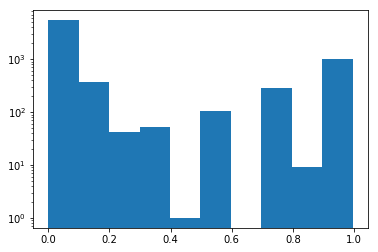

In [43]:
fig, ax = plt.subplots()
ax.hist([
    p[0]
    for p in preds
])
ax.set_yscale('log')

## Tune the Training

In [52]:
from metal.tuners.random_tuner import RandomSearchTuner
#label_model_everything_windows_tuned = LabelModel(k=2, seed=123)
random_tuner = RandomSearchTuner(LabelModel, seed=123, validation_metric='f1')

In [56]:
search_space = {
    'seed' : [123],
    'n_epochs': list(range(1000, 20000, 1000)),
    'lr': {'range': [1e-5, .1], 'scale': 'log'},
    'l2': {'range': [1e-5, .1], 'scale': 'log'},
    'log_train_every': [1000],
    'class_balance': [
        (i * .1, 1 - i * .1)
        for i in range(1, 10)
    ]
#     'Y_dev': [Y_test_windows]
}

In [57]:
best_random_model = random_tuner.search(search_space,
                                (L_test_windows, Y_test_windows),
                               train_args= [L_train_windows_all],
                               train_kwargs = {
#                                    'Y_dev': Y_test_windows
#                                    'class_balance': (0.2, 0.8)
                               },
                               init_kwargs={
                                   'k': 2
                               }, verbose=True)

[0] Testing {'seed': 123, 'n_epochs': 3000, 'log_train_every': 1000, 'class_balance': (0.1, 0.9), 'lr': 0.0015873253521826287, 'l2': 2.7625669859868665e-05}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.046]
[2000 epo]: TRAIN:[loss=0.044]
[3000 epo]: TRAIN:[loss=0.044]
Finished Training
[1] Testing {'seed': 123, 'n_epochs': 5000, 'log_train_every': 1000, 'class_balance': (0.8, 0.19999999999999996), 'lr': 9.970252808916706e-05, 'l2': 8.667477815191281e-05}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.068]
[2000 epo]: TRAIN:[loss=0.064]
[3000 epo]: TRAIN:[loss=0.062]
[4000 epo]: TRAIN:[loss=0.059]
[5000 epo]: TRAIN:[loss=0.057]
Finished Training
[2] Testing {'seed': 123, 'n_epochs': 8000, 'log_train_every': 1000, 'class_balance': (0.5, 0.5), 'lr': 0.0016956748298442602, 'l2': 1.0074373509148456e-05}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.044]
[2000 epo]: TRAIN:[loss=0.043]
[3000 epo]: TRAIN:[loss=0.043]
[4000 epo]: TRAIN:[loss=0.043]
[5000 e

[4000 epo]: TRAIN:[loss=0.051]
[5000 epo]: TRAIN:[loss=0.049]
[6000 epo]: TRAIN:[loss=0.047]
[7000 epo]: TRAIN:[loss=0.046]
[8000 epo]: TRAIN:[loss=0.045]
[9000 epo]: TRAIN:[loss=0.045]
Finished Training
[13] Testing {'seed': 123, 'n_epochs': 12000, 'log_train_every': 1000, 'class_balance': (0.30000000000000004, 0.7), 'lr': 5.428161320086563e-05, 'l2': 0.00020070483707215392}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.075]
[2000 epo]: TRAIN:[loss=0.068]
[3000 epo]: TRAIN:[loss=0.065]
[4000 epo]: TRAIN:[loss=0.062]
[5000 epo]: TRAIN:[loss=0.060]
[6000 epo]: TRAIN:[loss=0.058]
[7000 epo]: TRAIN:[loss=0.056]
[8000 epo]: TRAIN:[loss=0.055]
[9000 epo]: TRAIN:[loss=0.053]
[10000 epo]: TRAIN:[loss=0.052]
[11000 epo]: TRAIN:[loss=0.051]
[12000 epo]: TRAIN:[loss=0.050]
Finished Training
[14] Testing {'seed': 123, 'n_epochs': 5000, 'log_train_every': 1000, 'class_balance': (0.5, 0.5), 'lr': 0.02756945813324789, 'l2': 0.008584761532855074}
Computing O...
Estimating \mu...
[1000 ep

[4000 epo]: TRAIN:[loss=0.064]
[5000 epo]: TRAIN:[loss=0.062]
[6000 epo]: TRAIN:[loss=0.061]
[7000 epo]: TRAIN:[loss=0.060]
[8000 epo]: TRAIN:[loss=0.058]
[9000 epo]: TRAIN:[loss=0.057]
[10000 epo]: TRAIN:[loss=0.056]
[11000 epo]: TRAIN:[loss=0.055]
[12000 epo]: TRAIN:[loss=0.053]
Finished Training
[25] Testing {'seed': 123, 'n_epochs': 3000, 'log_train_every': 1000, 'class_balance': (0.5, 0.5), 'lr': 0.007207727943061394, 'l2': 2.5443643787253044e-05}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.043]
[2000 epo]: TRAIN:[loss=0.043]
[3000 epo]: TRAIN:[loss=0.043]
Finished Training
[26] Testing {'seed': 123, 'n_epochs': 4000, 'log_train_every': 1000, 'class_balance': (0.9, 0.09999999999999998), 'lr': 3.055079470619739e-05, 'l2': 0.045408079528874115}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.781]
[2000 epo]: TRAIN:[loss=0.091]
[3000 epo]: TRAIN:[loss=0.078]
[4000 epo]: TRAIN:[loss=0.077]
Finished Training
[27] Testing {'seed': 123, 'n_epochs': 11000, 'log_t

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.058]
[2000 epo]: TRAIN:[loss=0.051]
[3000 epo]: TRAIN:[loss=0.049]
[4000 epo]: TRAIN:[loss=0.048]
[5000 epo]: TRAIN:[loss=0.047]
[6000 epo]: TRAIN:[loss=0.047]
[7000 epo]: TRAIN:[loss=0.047]
[8000 epo]: TRAIN:[loss=0.047]
[9000 epo]: TRAIN:[loss=0.047]
[10000 epo]: TRAIN:[loss=0.047]
Finished Training
[39] Testing {'seed': 123, 'n_epochs': 3000, 'log_train_every': 1000, 'class_balance': (0.4, 0.6), 'lr': 0.03798388576779223, 'l2': 0.059143739476418516}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.046]
[2000 epo]: TRAIN:[loss=0.046]
[3000 epo]: TRAIN:[loss=0.046]
Finished Training
[40] Testing {'seed': 123, 'n_epochs': 18000, 'log_train_every': 1000, 'class_balance': (0.4, 0.6), 'lr': 5.262346612515016e-05, 'l2': 0.04145943343236475}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.089]
[2000 epo]: TRAIN:[loss=0.075]
[3000 epo]: TRAIN:[loss=0.070]
[4000 epo]: TRAIN:[loss=0.066]
[5000 epo]: TRAIN:[loss=0.0

[51] Testing {'seed': 123, 'n_epochs': 8000, 'log_train_every': 1000, 'class_balance': (0.2, 0.8), 'lr': 0.00017604514535290303, 'l2': 0.0015474381730032022}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.062]
[2000 epo]: TRAIN:[loss=0.056]
[3000 epo]: TRAIN:[loss=0.053]
[4000 epo]: TRAIN:[loss=0.050]
[5000 epo]: TRAIN:[loss=0.048]
[6000 epo]: TRAIN:[loss=0.047]
[7000 epo]: TRAIN:[loss=0.046]
[8000 epo]: TRAIN:[loss=0.045]
Finished Training
[52] Testing {'seed': 123, 'n_epochs': 10000, 'log_train_every': 1000, 'class_balance': (0.1, 0.9), 'lr': 0.00443858481574851, 'l2': 0.09381292589278163}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.051]
[2000 epo]: TRAIN:[loss=0.051]
[3000 epo]: TRAIN:[loss=0.051]
[4000 epo]: TRAIN:[loss=0.051]
[5000 epo]: TRAIN:[loss=0.051]
[6000 epo]: TRAIN:[loss=0.051]
[7000 epo]: TRAIN:[loss=0.051]
[8000 epo]: TRAIN:[loss=0.051]
[9000 epo]: TRAIN:[loss=0.051]
[10000 epo]: TRAIN:[loss=0.051]
Finished Training
[53] Testing {'seed': 123, 

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=1.167]
Finished Training
[64] Testing {'seed': 123, 'n_epochs': 16000, 'log_train_every': 1000, 'class_balance': (0.30000000000000004, 0.7), 'lr': 7.324004455310018e-05, 'l2': 0.0005718385203333324}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.071]
[2000 epo]: TRAIN:[loss=0.066]
[3000 epo]: TRAIN:[loss=0.062]
[4000 epo]: TRAIN:[loss=0.059]
[5000 epo]: TRAIN:[loss=0.056]
[6000 epo]: TRAIN:[loss=0.054]
[7000 epo]: TRAIN:[loss=0.053]
[8000 epo]: TRAIN:[loss=0.051]
[9000 epo]: TRAIN:[loss=0.050]
[10000 epo]: TRAIN:[loss=0.049]
[11000 epo]: TRAIN:[loss=0.048]
[12000 epo]: TRAIN:[loss=0.047]
[13000 epo]: TRAIN:[loss=0.047]
[14000 epo]: TRAIN:[loss=0.046]
[15000 epo]: TRAIN:[loss=0.046]
[16000 epo]: TRAIN:[loss=0.046]
Finished Training
[65] Testing {'seed': 123, 'n_epochs': 16000, 'log_train_every': 1000, 'class_balance': (0.9, 0.09999999999999998), 'lr': 0.05697682174759071, 'l2': 0.050497531246834114}
Computing O...
Esti

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.033]
[2000 epo]: TRAIN:[loss=0.033]
Finished Training
[77] Testing {'seed': 123, 'n_epochs': 2000, 'log_train_every': 1000, 'class_balance': (0.5, 0.5), 'lr': 0.00016138041380697903, 'l2': 0.0010975557634257552}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.071]
[2000 epo]: TRAIN:[loss=0.059]
Finished Training
[78] Testing {'seed': 123, 'n_epochs': 7000, 'log_train_every': 1000, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 0.006655261073914193, 'l2': 0.00013636055094250695}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.033]
[2000 epo]: TRAIN:[loss=0.033]
[3000 epo]: TRAIN:[loss=0.033]
[4000 epo]: TRAIN:[loss=0.033]
[5000 epo]: TRAIN:[loss=0.033]
[6000 epo]: TRAIN:[loss=0.033]
[7000 epo]: TRAIN:[loss=0.033]
Finished Training
[79] Testing {'seed': 123, 'n_epochs': 17000, 'log_train_every': 1000, 'class_balance': (0.1, 0.9), 'lr': 0.023897462197013133, 'l2': 0.0013615728348644368}
Com

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.070]
[2000 epo]: TRAIN:[loss=0.060]
[3000 epo]: TRAIN:[loss=0.054]
[4000 epo]: TRAIN:[loss=0.050]
[5000 epo]: TRAIN:[loss=0.048]
[6000 epo]: TRAIN:[loss=0.047]
[7000 epo]: TRAIN:[loss=0.046]
[8000 epo]: TRAIN:[loss=0.045]
[9000 epo]: TRAIN:[loss=0.045]
[10000 epo]: TRAIN:[loss=0.044]
[11000 epo]: TRAIN:[loss=0.044]
[12000 epo]: TRAIN:[loss=0.044]
[13000 epo]: TRAIN:[loss=0.044]
[14000 epo]: TRAIN:[loss=0.044]
[15000 epo]: TRAIN:[loss=0.044]
[16000 epo]: TRAIN:[loss=0.044]
Finished Training
[89] Testing {'seed': 123, 'n_epochs': 10000, 'log_train_every': 1000, 'class_balance': (0.4, 0.6), 'lr': 0.00031181626750720424, 'l2': 0.00913178130880986}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.060]
[2000 epo]: TRAIN:[loss=0.050]
[3000 epo]: TRAIN:[loss=0.046]
[4000 epo]: TRAIN:[loss=0.045]
[5000 epo]: TRAIN:[loss=0.044]
[6000 epo]: TRAIN:[loss=0.044]
[7000 epo]: TRAIN:[loss=0.044]
[8000 epo]: TRAIN:[loss=0.044]
[9000 ep

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.044]
[2000 epo]: TRAIN:[loss=0.044]
[3000 epo]: TRAIN:[loss=0.044]
[4000 epo]: TRAIN:[loss=0.044]
[5000 epo]: TRAIN:[loss=0.044]
[6000 epo]: TRAIN:[loss=0.044]
[7000 epo]: TRAIN:[loss=0.044]
[8000 epo]: TRAIN:[loss=0.044]
[9000 epo]: TRAIN:[loss=0.044]
[10000 epo]: TRAIN:[loss=0.044]
[11000 epo]: TRAIN:[loss=0.044]
[12000 epo]: TRAIN:[loss=0.044]
[13000 epo]: TRAIN:[loss=0.044]
[14000 epo]: TRAIN:[loss=0.044]
Finished Training
[102] Testing {'seed': 123, 'n_epochs': 10000, 'log_train_every': 1000, 'class_balance': (0.2, 0.8), 'lr': 0.01523441108464673, 'l2': 0.0009775104398773494}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.043]
[2000 epo]: TRAIN:[loss=0.043]
[3000 epo]: TRAIN:[loss=0.043]
[4000 epo]: TRAIN:[loss=0.043]
[5000 epo]: TRAIN:[loss=0.043]
[6000 epo]: TRAIN:[loss=0.043]
[7000 epo]: TRAIN:[loss=0.043]
[8000 epo]: TRAIN:[loss=0.043]
[9000 epo]: TRAIN:[loss=0.043]
[10000 epo]: TRAIN:[loss=0.043]
Finished 

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.044]
[2000 epo]: TRAIN:[loss=0.044]
[3000 epo]: TRAIN:[loss=0.044]
[4000 epo]: TRAIN:[loss=0.044]
[5000 epo]: TRAIN:[loss=0.044]
[6000 epo]: TRAIN:[loss=0.044]
[7000 epo]: TRAIN:[loss=0.044]
[8000 epo]: TRAIN:[loss=0.044]
[9000 epo]: TRAIN:[loss=0.044]
[10000 epo]: TRAIN:[loss=0.044]
[11000 epo]: TRAIN:[loss=0.044]
[12000 epo]: TRAIN:[loss=0.044]
[13000 epo]: TRAIN:[loss=0.044]
[14000 epo]: TRAIN:[loss=0.044]
Finished Training
[116] Testing {'seed': 123, 'n_epochs': 8000, 'log_train_every': 1000, 'class_balance': (0.8, 0.19999999999999996), 'lr': 0.0008782428985750514, 'l2': 0.004725287686654237}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.048]
[2000 epo]: TRAIN:[loss=0.039]
[3000 epo]: TRAIN:[loss=0.035]
[4000 epo]: TRAIN:[loss=0.034]
[5000 epo]: TRAIN:[loss=0.033]
[6000 epo]: TRAIN:[loss=0.033]
[7000 epo]: TRAIN:[loss=0.033]
[8000 epo]: TRAIN:[loss=0.033]
Finished Training
[117] Testing {'seed': 123, 'n_epochs'

Estimating \mu...
[1000 epo]: TRAIN:[loss=0.034]
[2000 epo]: TRAIN:[loss=0.033]
[3000 epo]: TRAIN:[loss=0.033]
[4000 epo]: TRAIN:[loss=0.033]
[5000 epo]: TRAIN:[loss=0.033]
[6000 epo]: TRAIN:[loss=0.033]
[7000 epo]: TRAIN:[loss=0.033]
Finished Training
[128] Testing {'seed': 123, 'n_epochs': 2000, 'log_train_every': 1000, 'class_balance': (0.1, 0.9), 'lr': 0.048621671156493136, 'l2': 0.0008024516009605468}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.043]
[2000 epo]: TRAIN:[loss=0.043]
Finished Training
[129] Testing {'seed': 123, 'n_epochs': 7000, 'log_train_every': 1000, 'class_balance': (0.8, 0.19999999999999996), 'lr': 0.011873380231527514, 'l2': 0.002261436426753004}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.033]
[2000 epo]: TRAIN:[loss=0.033]
[3000 epo]: TRAIN:[loss=0.033]
[4000 epo]: TRAIN:[loss=0.033]
[5000 epo]: TRAIN:[loss=0.033]
[6000 epo]: TRAIN:[loss=0.033]
[7000 epo]: TRAIN:[loss=0.033]
Finished Training
[130] Testing {'seed': 123, 'n_epochs

[3000 epo]: TRAIN:[loss=0.043]
[4000 epo]: TRAIN:[loss=0.043]
Finished Training
[141] Testing {'seed': 123, 'n_epochs': 13000, 'log_train_every': 1000, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 0.0003969716236034616, 'l2': 0.000995929670765251}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.052]
[2000 epo]: TRAIN:[loss=0.047]
[3000 epo]: TRAIN:[loss=0.046]
[4000 epo]: TRAIN:[loss=0.044]
[5000 epo]: TRAIN:[loss=0.042]
[6000 epo]: TRAIN:[loss=0.039]
[7000 epo]: TRAIN:[loss=0.036]
[8000 epo]: TRAIN:[loss=0.034]
[9000 epo]: TRAIN:[loss=0.034]
[10000 epo]: TRAIN:[loss=0.033]
[11000 epo]: TRAIN:[loss=0.033]
[12000 epo]: TRAIN:[loss=0.033]
[13000 epo]: TRAIN:[loss=0.033]
Finished Training
[142] Testing {'seed': 123, 'n_epochs': 12000, 'log_train_every': 1000, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 0.015641475162285878, 'l2': 5.417559254148598e-05}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.043]
[2000 epo]: TRAIN:[lo

Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.043]
[2000 epo]: TRAIN:[loss=0.043]
[3000 epo]: TRAIN:[loss=0.043]
Finished Training
[153] Testing {'seed': 123, 'n_epochs': 18000, 'log_train_every': 1000, 'class_balance': (0.8, 0.19999999999999996), 'lr': 2.3750468968836907e-05, 'l2': 0.0001572168238555211}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=1.255]
[2000 epo]: TRAIN:[loss=0.251]
[3000 epo]: TRAIN:[loss=0.085]
[4000 epo]: TRAIN:[loss=0.069]
[5000 epo]: TRAIN:[loss=0.067]
[6000 epo]: TRAIN:[loss=0.066]
[7000 epo]: TRAIN:[loss=0.065]
[8000 epo]: TRAIN:[loss=0.064]
[9000 epo]: TRAIN:[loss=0.064]
[10000 epo]: TRAIN:[loss=0.063]
[11000 epo]: TRAIN:[loss=0.063]
[12000 epo]: TRAIN:[loss=0.062]
[13000 epo]: TRAIN:[loss=0.062]
[14000 epo]: TRAIN:[loss=0.061]
[15000 epo]: TRAIN:[loss=0.060]
[16000 epo]: TRAIN:[loss=0.060]
[17000 epo]: TRAIN:[loss=0.059]
[18000 epo]: TRAIN:[loss=0.059]
Finished Training
[154] Testing {'seed': 123, 'n_epochs': 9000, 'log_train_every

[6000 epo]: TRAIN:[loss=0.082]
[7000 epo]: TRAIN:[loss=0.076]
[8000 epo]: TRAIN:[loss=0.073]
Finished Training
[164] Testing {'seed': 123, 'n_epochs': 19000, 'log_train_every': 1000, 'class_balance': (0.9, 0.09999999999999998), 'lr': 4.1963427954035935e-05, 'l2': 0.00020926770058269723}
Computing O...
Estimating \mu...
[1000 epo]: TRAIN:[loss=0.255]
[2000 epo]: TRAIN:[loss=0.074]
[3000 epo]: TRAIN:[loss=0.073]
[4000 epo]: TRAIN:[loss=0.073]
[5000 epo]: TRAIN:[loss=0.073]
[6000 epo]: TRAIN:[loss=0.072]
[7000 epo]: TRAIN:[loss=0.072]
[8000 epo]: TRAIN:[loss=0.072]
[9000 epo]: TRAIN:[loss=0.072]
[10000 epo]: TRAIN:[loss=0.071]
[11000 epo]: TRAIN:[loss=0.071]
[12000 epo]: TRAIN:[loss=0.071]
[13000 epo]: TRAIN:[loss=0.071]
[14000 epo]: TRAIN:[loss=0.070]
[15000 epo]: TRAIN:[loss=0.070]
[16000 epo]: TRAIN:[loss=0.070]
[17000 epo]: TRAIN:[loss=0.070]
[18000 epo]: TRAIN:[loss=0.069]
[19000 epo]: TRAIN:[loss=0.069]
Finished Training
[165] Testing {'seed': 123, 'n_epochs': 6000, 'log_train_every

In [59]:
best_random_model.save('tuned_label_model.pkl')